In [6]:
pip install pandas numpy matplotlib seaborn scikit-learn keras tensorflow


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_validate,StratifiedKFold
from keras.layers import Dense
from keras.models import Sequential
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report,roc_auc_score
from keras.layers import Dropout
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.utils import to_categorical

In [3]:
data = pd.read_csv('data.csv')
data_cleaned = data.drop(columns=['patient_id','er_status_measured_by_ihc'])
data_cleaned.head()

C:\Users\Husse\AppData\Local\Temp\ipykernel_12936\4014827458.py:1: DtypeWarning: Columns (662,664,676,677,683,685,686,687) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data.csv')


,cancer_type,age_at_diagnosis,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status,neoplasm_histologic_grade,her2_status_measured_by_snp6,her2_status,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,Breast Invasive Ductal Carcinoma,54.29,High,1,LumB,1,Positive,3.0,NEUTRAL,Negative,...,0,0,0,0,0,0,0,0,0,0
1,Breast Invasive Ductal Carcinoma,43.45,Moderate,0,LumA,4,Positive,1.0,LOSS,Negative,...,0,0,0,0,0,0,0,0,0,0
2,Breast Invasive Ductal Carcinoma,74.11,High,0,LumB,3,Positive,3.0,NEUTRAL,Negative,...,0,0,0,0,0,0,0,0,0,0
3,Breast Invasive Ductal Carcinoma,51.87,High,0,LumA,3,Positive,2.0,NEUTRAL,Negative,...,0,0,0,0,0,0,0,0,0,0
4,Breast Invasive Ductal Carcinoma,87.18,Moderate,0,LumB,1,Positive,3.0,GAIN,Positive,...,0,0,0,0,0,0,0,0,0,0


In [4]:
def fill_missing_with_mode(data):
    # Get a list of columns with missing values
    columns_with_missing_values = data.columns[data.isnull().any()].tolist()
    
    # Iterate over each column with missing values
    for column_name in columns_with_missing_values:
        # Loop until no more null values in the column
        while data[column_name].isnull().any():
            # Iterate over rows in the DataFrame
            for i, row in data[data[column_name].isnull()].iterrows():
                # Filter the data for the same cancer type
                same_type_data = data[data['cancer_type'] == row['cancer_type']]
                
                # Try to find 5 other entries; if fewer, take as many as available
                if len(same_type_data) > 5:
                    sample = same_type_data.sample(n=5)
                else:
                    sample = same_type_data
                
                # Calculate the mode of the selected sample
                mode_value = sample[column_name].mode()
                
                # If mode calculation is successful and not empty, use the mode to fill the missing value
                if not mode_value.empty:
                    data.at[i, column_name] = mode_value.iloc[0]
                else:
                    # If no mode available (all values are different or no other samples), we might choose to do nothing or use a global mode
                    # Here we're choosing to use the global mode as a fallback
                    global_mode = data[column_name].mode()[0]
                    data.at[i, column_name] = global_mode

    return data

# Example usage for the column 'cellularity'
updated_data = fill_missing_with_mode(data_cleaned)

missing_values = updated_data.isnull().sum()
columns_with_missing_values = missing_values[missing_values > 0]

# Display columns with missing values and their counts
print(columns_with_missing_values)

Series([], dtype: int64)


In [5]:
X = data_cleaned.drop(columns=['cancer_type'])
y = data_cleaned['cancer_type']

cols_one_hot = [col for col in X.columns if X[col].dtype == 'object' and X[col].nunique() <= 5]
cols_label = [col for col in X.columns if X[col].dtype == 'object' and X[col].nunique() > 5]

# Initialize the transformers list for the ColumnTransformer
transformers = []

# Loop through each column in X to apply appropriate encoding
for column in X.columns:
    if X[column].dtype == 'object' or X[column].dtype == 'int':  # Adjusted to ensure we catch int types too
        X[column] = X[column].astype(str)  # Convert everything to string to avoid mixed type errors
        unique_values = X[column].nunique()
        if unique_values > 5:
            # Use LabelEncoder for columns with more than 5 unique values
            transformers.append((column, LabelEncoder(), [column]))  # LabelEncoder usage adjusted
        else:
            # Use OneHotEncoder for columns with 5 or fewer unique values
            transformers.append((column, OneHotEncoder(), [column]))

# Manually apply LabelEncoder to the relevant columns before ColumnTransformer
for name, encoder, columns in transformers:
    if isinstance(encoder, LabelEncoder):
        X[columns[0]] = encoder.fit_transform(X[columns[0]])  # Directly encode the column in the DataFrame
        # Remove label encoded columns from transformer list since they are already processed
        transformers = [(n, e, c) for n, e, c in transformers if e is not LabelEncoder]

# Setup remaining transformations with OneHotEncoder using ColumnTransformer
preprocessor_X = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), [name for name, encoder, _ in transformers if isinstance(encoder, OneHotEncoder)])
    ],
    remainder='passthrough'  # Keep all other columns that do not need encoding
)

# Fit and transform X with the defined ColumnTransformer for OneHotEncoder
X_transformed = preprocessor_X.fit_transform(X)

# Label encode y
label_encoder_y = LabelEncoder()
y_encoded = label_encoder_y.fit_transform(y)

# Print the final shape of X_transformed to verify feature count
print("Number of features in X after encoding:", X_transformed.shape[1])

Number of features in X after encoding: 734


In [6]:
from IPython.display import display
import pandas as pd

# Assume cols_label and cols_one_hot are defined and scoped correctly from a previous cell
onehot_features = preprocessor_X.named_transformers_['onehot'].get_feature_names_out()
label_features = cols_label  # Using the columns designated for label encoding
remainder_features = [col for col in X.columns if col not in cols_one_hot and col not in cols_label]

# Combining all feature names
all_features = list(onehot_features) + label_features + remainder_features

# Create the DataFrame from the transformed data
X_transformed_df = pd.DataFrame(X_transformed, columns=all_features[:X_transformed.shape[1]])

# Verify column counts and consistency
if len(all_features[:X_transformed.shape[1]]) != X_transformed_df.shape[1]:
    print(f"Warning: Column count mismatch. {len(all_features[:X_transformed.shape[1]])} names for {X_transformed_df.shape[1]} actual columns.")
else:
    print("Column names and counts are consistent.")

# Find the index of 'muc16_mut' column
muc16_mut_index = X_transformed_df.columns.get_loc("muc16_mut")

# Select columns after 'muc16_mut'
selected_columns = X_transformed_df.columns[muc16_mut_index + 1:]

# Display the selected columns for the first 30 rows of the DataFrame
display(X_transformed_df[selected_columns].head())


Column names and counts are consistent.


,ahnak2_mut,kmt2c_mut,syne1_mut,gata3_mut,map3k1_mut,ahnak_mut,dnah11_mut,cdh1_mut,dnah2_mut,kmt2d_mut,...,spry2,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17
0,3.0,1.0,3.0,2.0,5.160,111.100000,0.0,1.0,80.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,7.0,2.046,76.866667,1.0,1.0,23.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,1.0,6.0,3.0,6.056,118.700000,0.0,1.0,28.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,0.0,0.0,10.0,3.028,220.233333,1.0,1.0,14.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,1.0,2.0,1.0,5.052,28.600000,0.0,0.0,26.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
from sklearn.preprocessing import StandardScaler

start_index = X_transformed_df.columns.get_loc("brca1")
end_index = X_transformed_df.columns.get_loc("ugt2b17") +1

# Select the columns for scaling
columns_to_scale = X_transformed_df.columns[start_index:end_index]

# Initialize the StandardScaler
scaler = StandardScaler()

# Scale the selected columns
X_transformed_df[columns_to_scale] = scaler.fit_transform(X_transformed_df[columns_to_scale])

# Display the scaled data for these columns
print(X_transformed_df[columns_to_scale].head())

      brca1     brca2     palb2      pten      tp53       atm      cdh1  \
0 -1.211576 -0.109631 -0.594727 -1.140829  0.595648 -1.106277 -2.143642   
1  0.427194 -0.010864 -0.736981  0.064916  0.152814  0.097883  0.103718   
2 -0.477025 -0.151244 -0.772095 -0.847137  0.240765 -0.248629 -0.571054   
3 -0.548368  0.201905 -0.655579 -0.891006 -0.371917  1.477406  0.814926   
4  0.972271  0.990202 -0.241689  0.815784  0.212176  0.843807 -0.182637   

      chek2       nbn       nf1  ...     spry2    srd5a1    srd5a2    srd5a3  \
0 -1.105545 -0.703869 -0.394923  ... -0.057008 -0.069081 -0.062535 -0.065305   
1 -0.322918  0.518080 -0.696819  ... -0.057008 -0.069081 -0.062535 -0.065305   
2  0.063015  0.116458  0.202719  ... -0.057008 -0.069081 -0.062535 -0.065305   
3  0.903104  0.189407 -0.800239  ... -0.057008 -0.069081 -0.062535 -0.065305   
4 -0.134838 -0.517778  1.051354  ... -0.057008 -0.069081 -0.062535 -0.065305   

        st7      star      tnk2     tulp4   ugt2b15   ugt2b17  
0 -0

In [24]:
import numpy as np
from sklearn.model_selection import train_test_split

# Assume X_transformed_df and y_encoded are your features and labels respectively

# First, isolate all Class 2 instances
class_2_indices = (y_encoded == 2)
X_class_2 = X_transformed_df[class_2_indices]
y_class_2 = y_encoded[class_2_indices]

# Remove Class 2 instances from the original dataset
X_non_class_2 = X_transformed_df[~class_2_indices]
y_non_class_2 = y_encoded[~class_2_indices]

# Split the non-Class 2 data into training and remaining (validation + test) sets
X_train, X_remaining, y_train, y_remaining = train_test_split(
    X_non_class_2, y_non_class_2, train_size=0.8, random_state=42, stratify=y_non_class_2
)

# Split the remaining non-Class 2 data into validation and test sets
X_valid, X_test_non_class_2, y_valid, y_test_non_class_2 = train_test_split(
    X_remaining, y_remaining, test_size=0.5, random_state=42, stratify=y_remaining
)

# Combine the non-Class 2 test instances with all Class 2 instances to form the final test set
X_test = np.concatenate((X_test_non_class_2, X_class_2))
y_test = np.concatenate((y_test_non_class_2, y_class_2))

# Print the sizes of each dataset to confirm the splits
print("Training set size:", X_train.shape, y_train.shape)
print("Validation set size:", X_valid.shape, y_valid.shape)
print("Test set size:", X_test.shape, y_test.shape)


Training set size: (1182, 734) (1182,)
Validation set size: (148, 734) (148,)
Test set size: (166, 734) (166,)


In [26]:
# Convert y_train to a pandas Series for easy counting
y_train_series = pd.Series(y_train)

# Get counts of each class
class_counts_train = y_train_series.value_counts()

# Print the counts with original class names using inverse transform of LabelEncoder
class_names_counts_train = pd.Series(class_counts_train.index).apply(
    lambda x: label_encoder_y.inverse_transform([x])[0])
class_counts_train.index = class_names_counts_train

# Display the class counts with names
print(class_counts_train)

# Class Number 0: Breast Invasive Ductal Carcinoma
# Class Number 1: Breast Invasive Lobular Carcinoma
# Class Number 2: Breast Invasive Mixed Mucinous Carcinoma
# Class Number 3: Breast Mixed Ductal and Lobular Carcinoma


Breast Invasive Ductal Carcinoma             959
Breast Mixed Ductal and Lobular Carcinoma    132
Breast Invasive Lobular Carcinoma             91
Name: count, dtype: int64


In [27]:
# from sklearn.utils.class_weight import compute_class_weight
# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(y_train),
#     y=y_train
# )
# class_weight_dict = dict(enumerate(class_weights))

In [28]:
# from keras.optimizers import Adam
# from keras.callbacks import EarlyStopping
# from keras.layers import Dropout
# from keras.regularizers import l2
# from keras.layers import BatchNormalization
# num_classes = len(np.unique(y_train))

# model = Sequential([
#     Dense(900, activation='relu', input_shape=(X_train.shape[1],)),
#     Dropout(0.2),
#     Dense(512, activation='relu'),
#     Dropout(0.2),
#     Dense(256, activation='relu'),
#     Dropout(0.2),
#     Dense(128, activation='relu'),
#     Dense(64, activation='relu'),
#     Dense(num_classes, activation='softmax')
# ])

# # Set the learning rate
# learning_rate = 0.01  # You can change this value according to your needs

# # Instantiate the optimizer with the desired learning rate
# adam_optimizer = Adam(learning_rate=learning_rate)

# # Compile the model with the customized optimizer
# model.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [29]:
# history = model.fit(X_train, y_train, epochs=100, batch_size=600,
#                     validation_data=(X_valid, y_valid),
#                     class_weight=class_weight_dict)

In [30]:
# import matplotlib.pyplot as plt

# # Summarize history for accuracy
# plt.figure(figsize=(10, 5))
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(loc='upper left')
# plt.show()

# # Summarize history for loss
# plt.figure(figsize=(10, 5))
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(loc='upper right')
# plt.show()


In [31]:
# y_pred = model.predict(X_valid)

# # Convert the predicted probabilities to class labels
# y_pred_labels = np.argmax(y_pred, axis=1)

# # Generate the classification report
# report = classification_report(y_valid, y_pred_labels)

# # Print the classification report
# print(report)

In [29]:
pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [32]:
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

# Assuming y_train contains the class labels, and X_train contains the features

# Setup the RandomUnderSampler to reduce class 0 to 500 instances
rus = RandomUnderSampler(sampling_strategy={0: 500})

# Apply the resampling to the training data
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Check the new class distribution to ensure it is as expected
print("New class distribution:", np.bincount(y_resampled))

# Now X_resampled and y_resampled contain the undersampled data where class 0 has exactly 500 instances

New class distribution: [500  91   0 132]


In [33]:
y_train_binary = (y_train == 0).astype(int)  # 1 for 'Breast Invasive Ductal Carcinoma', 0 otherwise
y_valid_binary = (y_valid == 0).astype(int)

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l2

# Define class weights for balancing
class_weights = {
    0: 7,  # for 'Other Classes'
    1: 1   # for 'Breast Invasive Ductal Carcinoma'
}

# Model construction with simplified architecture
model_class_0 = Sequential([
    Dense(250, activation='relu'),
    Dropout(0.2),# Reduced number of neurons
    Dense(100, activation='relu'),
    Dense(50, activation='relu'),
    Dense(20, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

adam_optimizer = Adam(learning_rate=0.001)


model_class_0.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Training the model with adjusted parameters
history = model_class_0.fit(X_train, y_train_binary, epochs=100, batch_size=200,  # Increased epochs, reduced batch size
                    validation_data=(X_valid, y_valid_binary),
                    class_weight=class_weights)


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.6997 - loss: 3.2654 - val_accuracy: 0.2568 - val_loss: 1.2228
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3648 - loss: 1.5959 - val_accuracy: 0.2365 - val_loss: 0.9916
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3028 - loss: 1.4955 - val_accuracy: 0.3919 - val_loss: 0.7500
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4019 - loss: 1.4346 - val_accuracy: 0.4797 - val_loss: 0.7138
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4077 - loss: 1.3453 - val_accuracy: 0.4527 - val_loss: 0.7952
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4252 - loss: 1.3046 - val_accuracy: 0.5946 - val_loss: 0.7133
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4990 - loss: 1.2376 - val_accuracy: 0.6486 - val_loss: 0.6821
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5239 - loss: 1.1937 - val_accuracy: 0.5541 - val_loss: 0.7211

In [34]:
# Assuming 'model' and 'X_valid' are already defined and model is trained

# Predict the probabilities for the validation set
y_pred_probs = model_class_0.predict(X_valid)

# Convert probabilities to binary predictions with a threshold of 0.5
y_pred_binary = (y_pred_probs > 0.5).astype(int)

# Generate and print the classification report
report = classification_report(y_valid_binary, y_pred_binary, target_names=['Other Classes', 'Breast Invasive Ductal Carcinoma'])
print("Classification Report:\n", report)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Classification Report:
                                   precision    recall  f1-score   support

                   Other Classes       0.28      0.32      0.30        28
Breast Invasive Ductal Carcinoma       0.84      0.81      0.82       120

                        accuracy                           0.72       148
                       macro avg       0.56      0.56      0.56       148
                    weighted avg       0.73      0.72      0.72       148



In [35]:
# Assuming y_train and y_valid contain class labels
# Let's say 'Class 1' is the new focus, adapt y_train_binary and y_valid_binary accordingly
y_train_binary = (y_resampled == 1).astype(int)  # 1 for 'Class 1', 0 for others
y_valid_binary = (y_valid == 1).astype(int)

# Update class weights if needed
class_weight_dict = {
    0: 1,       # Normal weight for 'Other Classes'
    1: 6       # Increased weight for 'Class 1'
}
input_shape = X_train.shape[1]  # Number of input features

# Construct a new model architecture
model_class_1 = Sequential([
    Dense(250, activation='relu', input_shape=(input_shape,)),
    Dropout(0.3),
    Dense(156, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Set the learning rate
learning_rate = 0.001

# Instantiate the optimizer with the desired learning rate
adam_optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the customized optimizer
model_class_1.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the new model
history_class_1 = model_class_1.fit(X_resampled, y_train_binary, epochs=100, batch_size=50,
                                    validation_data=(X_valid, y_valid_binary),
                                    class_weight=class_weight_dict)

Epoch 1/100


C:\Users\Husse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5220 - loss: 3.0588 - val_accuracy: 0.3986 - val_loss: 0.8355
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5910 - loss: 1.5580 - val_accuracy: 0.4392 - val_loss: 0.8314
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6280 - loss: 1.2589 - val_accuracy: 0.2838 - val_loss: 1.0081
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6305 - loss: 1.1355 - val_accuracy: 0.6892 - val_loss: 0.5470
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6451 - loss: 1.1657 - val_accuracy: 0.8784 - val_loss: 0.3003
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7642 - loss: 0.9538 - val_accuracy: 0.7973 - val_loss: 0.4071
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7975 - loss: 0.8959 - val_accuracy: 0.6622 - val_loss: 0.6045
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7701 - loss: 0.6853 - val_accuracy: 0.8176 - val_loss: 0.

In [36]:
# Predict the probabilities for the validation set
y_pred_probs_class_1 = model_class_1.predict(X_valid)

# Convert probabilities to binary predictions with a threshold of 0.5
y_pred_binary_class_1 = (y_pred_probs_class_1 > 0.5).astype(int)

# Generate and print the classification report
report_class_1 = classification_report(y_valid_binary, y_pred_binary_class_1, 
                                       target_names=['Other Classes', 'Class 1'])
print("Classification Report for Class 1:\n", report_class_1)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Classification Report for Class 1:
                precision    recall  f1-score   support

Other Classes       0.93      0.93      0.93       137
      Class 1       0.18      0.18      0.18        11

     accuracy                           0.88       148
    macro avg       0.56      0.56      0.56       148
 weighted avg       0.88      0.88      0.88       148



In [55]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import numpy as np

# Assuming y_train and y_valid contain class labels

# Binarize y_train and y_valid so that 'Class 3' is 1 and all other classes are 0
y_train_binary = (y_train == 3).astype(int)
y_valid_binary = (y_valid == 3).astype(int)

# Balancing the dataset with a combination of SMOTE and RandomUnderSampler
smote = SMOTE(sampling_strategy={1: int(len(y_train_binary[y_train_binary == 0]) * 0.5)})  # Increase minority to 50% of majority
under = RandomUnderSampler(sampling_strategy={0: len(y_train_binary[y_train_binary == 1]) * 2})  # Reduce majority to double of minority
pipeline = Pipeline([('smote', smote), ('under', under)])
X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train_binary)

# Recalculate class weights after resampling
class_weights = compute_class_weight('balanced', classes=np.unique(y_resampled), y=y_resampled)
class_weight_dict = dict(enumerate(class_weights))

# Neural network model
model_class_3 = Sequential([
    Dense(128, input_dim=X_resampled.shape[1]),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),
    Dense(64),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),
    Dense(32),
    Activation('relu'),
    Dense(1, activation='sigmoid')
])

# Compile model
optimizer = Adam(learning_rate=0.001)
model_class_3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train model
history = model_class_3.fit(
    X_resampled, y_resampled,
    epochs=100,
    batch_size=50,
    validation_data=(X_valid, y_valid_binary),
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

Epoch 1/100


C:\Users\Husse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4869 - loss: 0.7313 - val_accuracy: 0.3919 - val_loss: 0.9218
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7143 - loss: 0.5854 - val_accuracy: 0.3851 - val_loss: 0.9580
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7292 - loss: 0.5355 - val_accuracy: 0.5676 - val_loss: 0.7610
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8204 - loss: 0.4348 - val_accuracy: 0.6149 - val_loss: 0.6508
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8951 - loss: 0.3541 - val_accuracy: 0.7365 - val_loss: 0.5123
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9325 - loss: 0.2699 - val_accuracy: 0.6689 - val_loss: 0.6624
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9558 - loss: 0.1750 - val_accuracy: 0.7365 - val_loss: 0.5302
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9858 - loss: 0.1134 - val_accuracy: 0.7635 - val_loss: 0.

In [56]:
# Evaluate the model's performance
val_predictions = model_class_3.predict(X_valid)
val_predictions_binary = (val_predictions > 0.5).astype(int)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_valid_binary, val_predictions)
print(f"Validation ROC AUC: {roc_auc:.2f}")

# Generate and print classification report
report = classification_report(y_valid_binary, val_predictions_binary, target_names=['Other Classes', 'Class 3'])
print("Classification Report for Class 3:\n", report)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Validation ROC AUC: 0.67
Classification Report for Class 3:
                precision    recall  f1-score   support

Other Classes       0.90      0.79      0.84       131
      Class 3       0.16      0.29      0.20        17

     accuracy                           0.74       148
    macro avg       0.53      0.54      0.52       148
 weighted avg       0.81      0.74      0.77       148



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

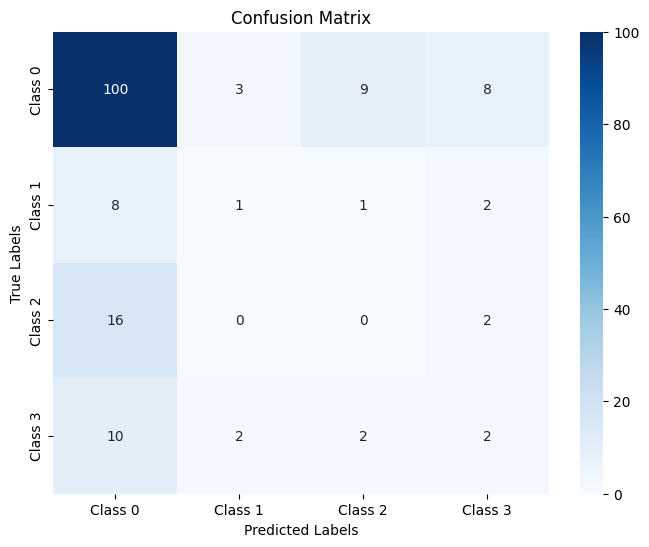


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.75      0.83      0.79       120
     Class 1       0.17      0.08      0.11        12
     Class 2       0.00      0.00      0.00        18
     Class 3       0.14      0.12      0.13        16

    accuracy                           0.62       166
   macro avg       0.26      0.26      0.26       166
weighted avg       0.57      0.62      0.59       166



In [57]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Predefined model accuracies
model_accuracies = {
    'model_0': 0.90,  # Example accuracy for model_0
    'model_1': 0.85,  # Example accuracy for model_1
    'model_3': 0.88   # Example accuracy for model_3
}

def predict_with_customization(X_test, y_test, model_0, model_1, model_3):
    predictions = []

    X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
    X_test = tf.reshape(X_test, [-1, 734])  # Adjust to the correct feature size

    for i in range(X_test.shape[0]):
        try:
            example = X_test[i]
            example = tf.expand_dims(example, axis=0)

            # Predict using all three models
            pred_0 = model_0.predict(example)[0, 0]
            pred_1 = model_1.predict(example)[0, 0]
            pred_3 = model_3.predict(example)[0, 0]

            # Collect predictions based on the threshold
            votes = [(0, pred_0 >= 0.5), (1, pred_1 >= 0.5), (3, pred_3 >= 0.5)]
            active_votes = [v[0] for v in votes if v[1]]

            # Decide the final prediction based on majority or the highest accuracy in the case of a tie
            if len(active_votes) == 0:
                predictions.append(2)  # Default to class 2 if no model is confident
            elif len(set(active_votes)) == 1:
                predictions.append(active_votes[0])  # Only one class predicted
            else:
                # In case of a tie, use the model with the highest accuracy among the predicted classes
                predicted_class = max(active_votes, key=lambda x: model_accuracies[f'model_{x}'])
                predictions.append(predicted_class)

        except Exception as e:
            print(f"Error processing example {i}: {e}")
            predictions.append(2)  # Fallback to class 2 on error

    predictions = np.array(predictions)
    report = classification_report(y_test, predictions, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
    cm = confusion_matrix(y_test, predictions)

    print("Confusion Matrix:")
    print(cm)

    # Visualizing the confusion matrix
    import matplotlib.pyplot as plt
    import seaborn as sns
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'],
                yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    print("\nClassification Report:")
    print(report)



predict_with_customization(X_test, y_test, model_class_0, model_class_1, model_class_3)
